<a href="https://colab.research.google.com/github/NicoMittenzwey/pv-load-sim/blob/main/Lastgang_Jahreszeiten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
First, let's install the required libraries and import them.

In [6]:
!pip install pandas numpy matplotlib

import pandas as pd
import numpy as np
from datetime import datetime, time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import files
from ipywidgets import widgets
from IPython.display import display
import io

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


# Upload Your Data
You need to upload two CSV files:

energy_consumption.csv: Contains energy consumption data
energy_generation.csv: Contains energy generation data

Both files should have columns: 'Start Date', 'Start Time', and 'kW'.

In [2]:
uploaded = files.upload()

# Get the uploaded filenames
consumption_file = [f for f in uploaded.keys() if 'consumption' in f.lower()][0]
generation_file = [f for f in uploaded.keys() if 'generation' in f.lower()][0]

# Read the CSV files
df_consumption = pd.read_csv(io.BytesIO(uploaded[consumption_file]))
df_generation = pd.read_csv(io.BytesIO(uploaded[generation_file]))

print("Data uploaded successfully!")

Saving energy_consumption.csv to energy_consumption.csv
Saving energy_generation.csv to energy_generation.csv
Data uploaded successfully!


# Generation Scaling

In [17]:
scaling_factor = widgets.FloatSlider(
    value=1.0,
    min=0.1,
    max=5.0,
    step=0.1,
    description='Generation Scaling Factor:',
    continuous_update=False,
    readout_format='.2f'
)

display(scaling_factor)

print("Please adjust the scaling factor for generation data using the slider above.")
print("Default is 1.0 (no scaling). The analysis will update when you change the value.")

FloatSlider(value=1.0, continuous_update=False, description='Generation Scaling Factor:', max=5.0, min=0.1)

Please adjust the scaling factor for generation data using the slider above.
Default is 1.0 (no scaling). The analysis will update when you change the value.
Data processed with scaling factor: 1.20


# Data Processing
Now, let's process the data and prepare it for analysis.



In [19]:
def process_data(df, is_generation=False):
    df['datetime'] = pd.to_datetime(df['Start Date'] + ' ' + df['Start Time'], errors='coerce')
    df = df.dropna(subset=['datetime'])
    df['kW'] = pd.to_numeric(df['kW'], errors='coerce')
    if is_generation:
        df['kW'] *= scaling_factor.value  # Apply scaling to generation data
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6])
    df['season'] = df['datetime'].dt.date.apply(get_season)
    return df

def update_data(*args):
    global df_consumption, df_generation
    df_consumption = process_data(pd.read_csv(io.BytesIO(uploaded[consumption_file])))
    df_generation = process_data(pd.read_csv(io.BytesIO(uploaded[generation_file])), is_generation=True)
    print(f"Data processed with scaling factor: {scaling_factor.value:.2f}")

scaling_factor.observe(update_data, names='value')
update_data()

def get_season(date):
    month = date.month
    day = date.day

    winter_mid = datetime(date.year, 12, 21).date()
    spring_mid = datetime(date.year, 3, 21).date()
    summer_mid = datetime(date.year, 6, 21).date()
    autumn_mid = datetime(date.year, 9, 21).date()

    if date.month < 3:
        winter_mid = datetime(date.year - 1, 12, 21).date()

    date_ordinal = date.toordinal()

    distances = [
        (abs(date_ordinal - winter_mid.toordinal()), 'Winter'),
        (abs(date_ordinal - spring_mid.toordinal()), 'Spring'),
        (abs(date_ordinal - summer_mid.toordinal()), 'Summer'),
        (abs(date_ordinal - autumn_mid.toordinal()), 'Autumn')
    ]

    return min(distances, key=lambda x: x[0])[1]

# Process the data
df_consumption = process_data(df_consumption)
df_generation = process_data(df_generation, is_generation=True)


print(f"Data processed successfully! Generation data scaled by factor: {scaling_factor.value}")

Data processed with scaling factor: 1.20
Data processed successfully! Generation data scaled by factor: 1.2


# Analysis Functions
Here are the functions we'll use for our analysis.

In [9]:
def identify_potential_holidays(df):
    daily_consumption = df.groupby(df['datetime'].dt.date)['kW'].sum().reset_index()
    daily_consumption['datetime'] = pd.to_datetime(daily_consumption['datetime'])
    daily_consumption['is_weekend'] = daily_consumption['datetime'].dt.dayofweek.isin([5, 6])

    weekday_consumption = daily_consumption[~daily_consumption['is_weekend']]['kW']
    weekend_consumption = daily_consumption[daily_consumption['is_weekend']]['kW']

    weekday_mean = weekday_consumption.mean()
    weekday_std = weekday_consumption.std()
    daily_consumption['z_score'] = (daily_consumption['kW'] - weekday_mean) / weekday_std

    weekend_threshold = weekend_consumption.mean()
    potential_holidays = daily_consumption[
        (~daily_consumption['is_weekend']) &
        (daily_consumption['kW'] < weekend_threshold) &
        (daily_consumption['z_score'] < -1.5)
    ]['datetime'].dt.date.tolist()

    return potential_holidays

def get_day_data(df, date=None, is_weekend=None, potential_holidays=[], is_generation=False):
    if date is not None:
        day_data = df[df['datetime'].dt.date == date].copy()
    elif is_weekend is not None:
        if not is_weekend and not is_generation:
            df = df[~df['datetime'].dt.date.isin(potential_holidays)]
        day_data = df[df['is_weekend'] == is_weekend].groupby(df['datetime'].dt.time).agg({'kW': 'mean'}).reset_index()
    else:
        day_data = df.groupby(df['datetime'].dt.time).agg({'kW': 'mean'}).reset_index()

    day_data['datetime'] = pd.to_datetime(day_data['datetime'].astype(str))
    day_data['minutes'] = day_data['datetime'].dt.hour * 60 + day_data['datetime'].dt.minute
    return day_data

print("Analysis functions defined successfully!")

Analysis functions defined successfully!


# Run the Analysis
Now, let's run the analysis and create the plots.

Potential holidays detected: [datetime.date(2024, 3, 29), datetime.date(2024, 5, 1), datetime.date(2024, 5, 20)]
No data available for Winter. Skipping this season.

Spring:
Average weekday consumption: 4.31 kW
Average weekend consumption: 2.11 kW
Max weekday consumption: 4.99 kW (on 2024-04-25)
Min consumption: 1.98 kW (on 2024-04-07)
Average generation (scaled): 4.64 kW

Summer:
Average weekday consumption: 4.05 kW
Average weekend consumption: 2.11 kW
Max weekday consumption: 4.92 kW (on 2024-06-13)
Min consumption: 1.94 kW (on 2024-05-20)
Average generation (scaled): 6.06 kW
No data available for Autumn. Skipping this season.


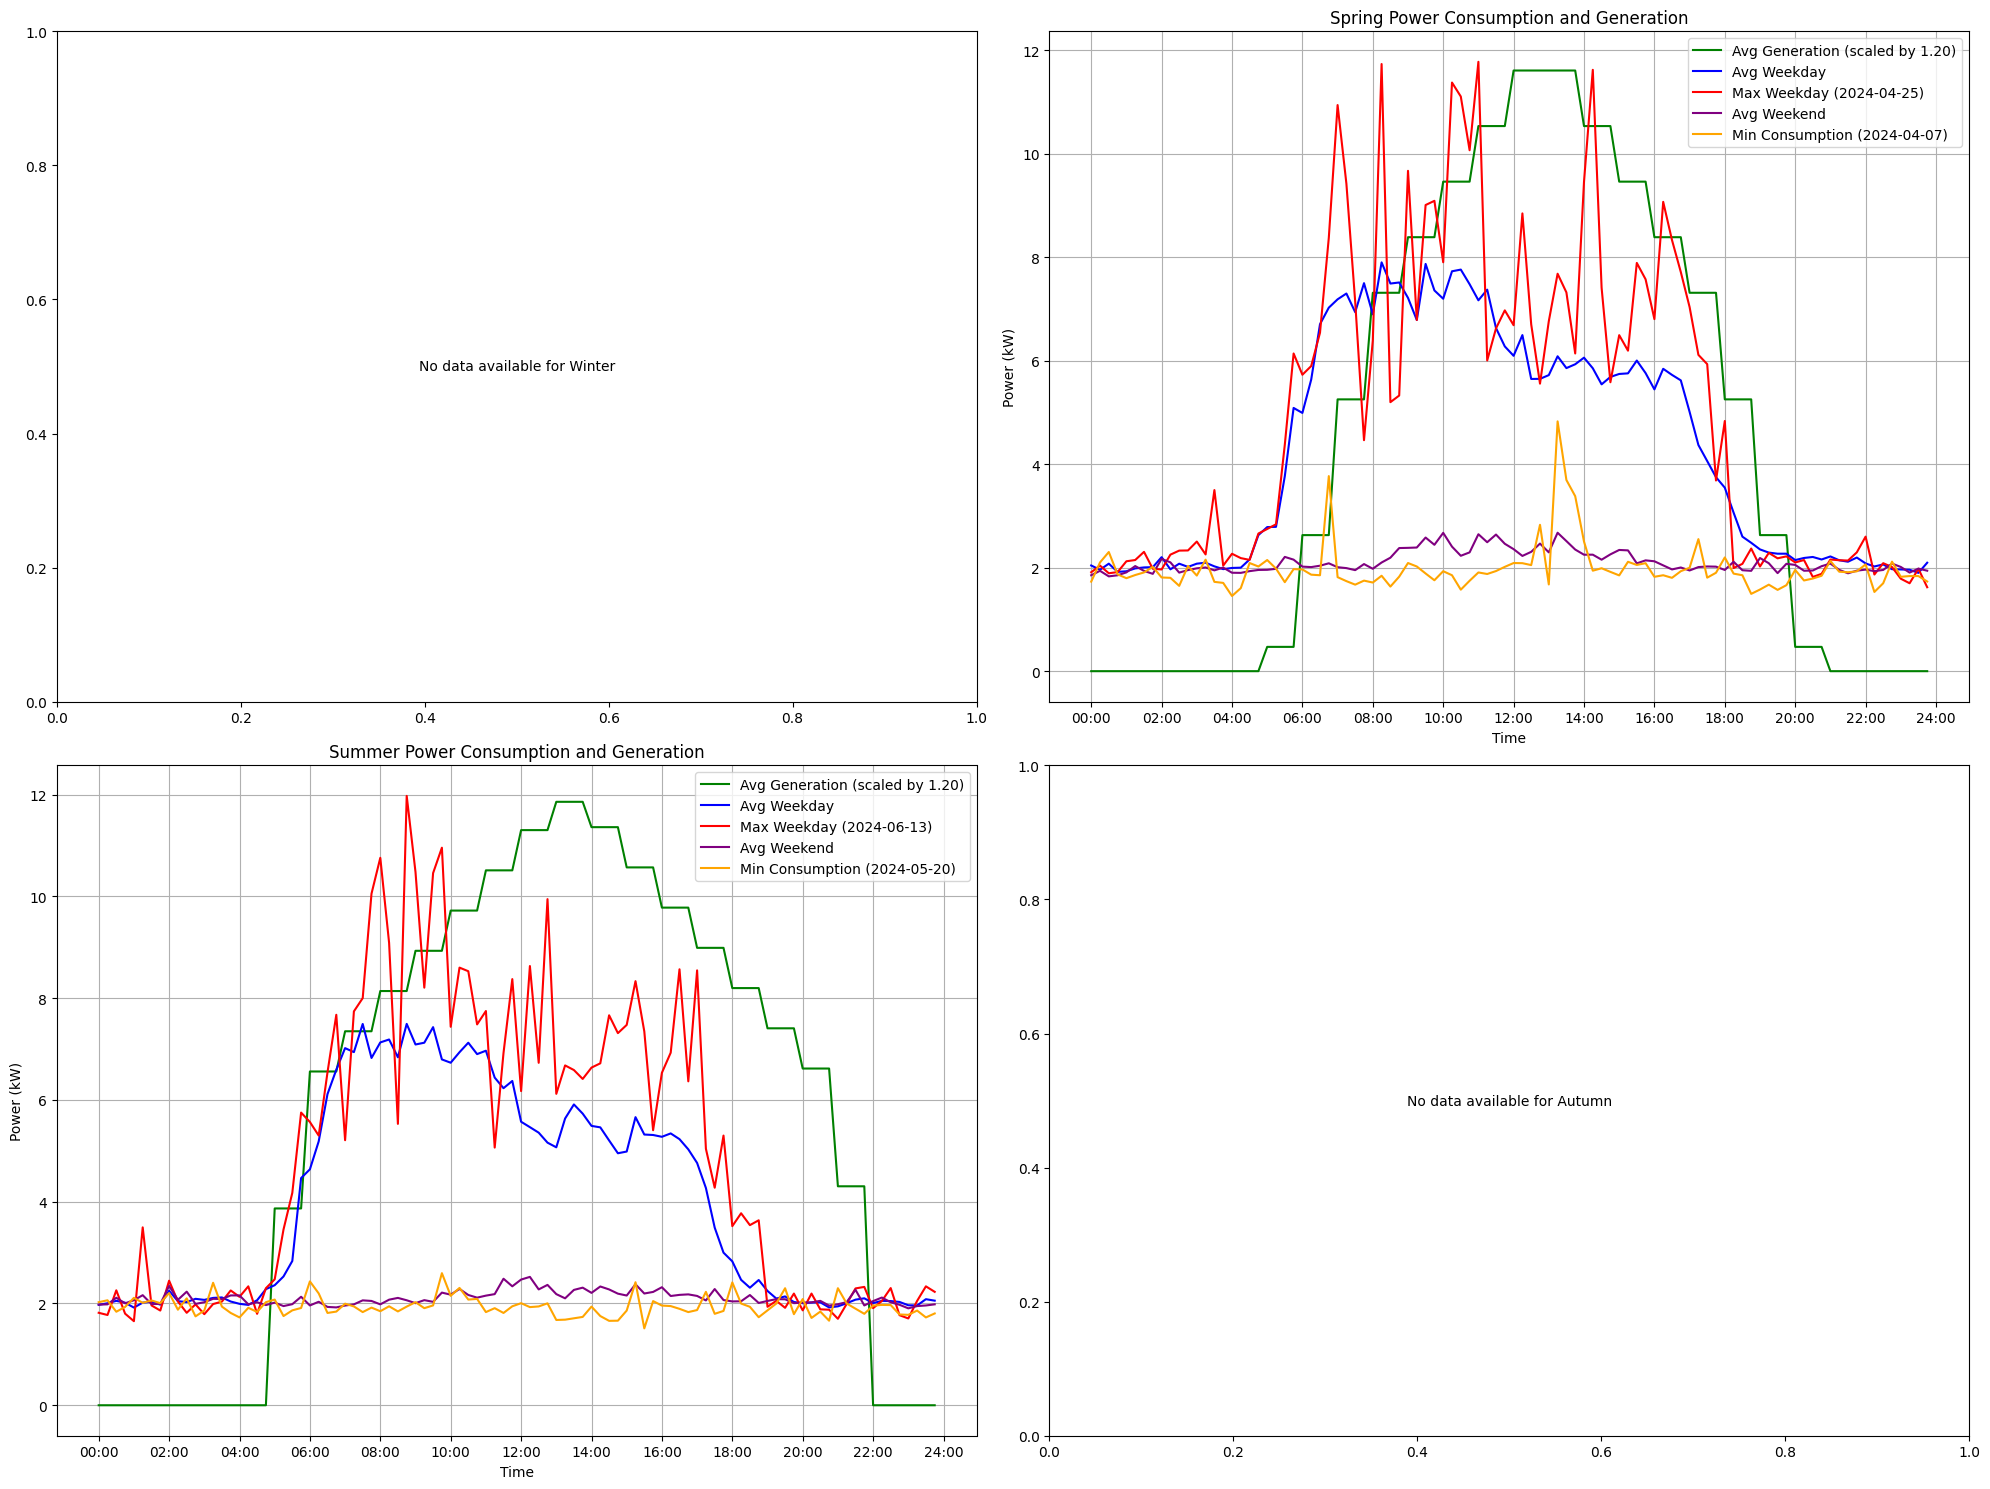


Original analysis completed with Generation Scaling Factor: 1.20


In [23]:
def run_original_analysis(*args):
    global df_consumption, df_generation

    # Identify potential holidays
    potential_holidays = identify_potential_holidays(df_consumption)
    print("Potential holidays detected:", potential_holidays)

    # Calculate daily total consumption and generation
    daily_consumption = df_consumption.groupby([df_consumption['datetime'].dt.date, 'season'])['kW'].sum().reset_index()
    daily_generation = df_generation.groupby([df_generation['datetime'].dt.date, 'season'])['kW'].sum().reset_index()

    # Ensure datetime column is properly formatted
    daily_consumption['datetime'] = pd.to_datetime(daily_consumption['datetime'])
    daily_generation['datetime'] = pd.to_datetime(daily_generation['datetime'])

    # Create a plot for each season
    seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    axs = axs.ravel()

    for idx, season in enumerate(seasons):
        season_consumption = df_consumption[df_consumption['season'] == season]
        season_generation = df_generation[df_generation['season'] == season]
        season_daily_consumption = daily_consumption[daily_consumption['season'] == season]

        if season_daily_consumption.empty:
            print(f"No data available for {season}. Skipping this season.")
            axs[idx].text(0.5, 0.5, f"No data available for {season}",
                          ha='center', va='center', transform=axs[idx].transAxes)
            continue

        # Find max weekday consumption day for the season
        max_weekday_consumption = season_daily_consumption[
            ~season_daily_consumption['datetime'].dt.dayofweek.isin([5, 6]) &
            ~season_daily_consumption['datetime'].dt.date.isin(potential_holidays)
        ]['kW'].max()
        max_weekday_date = season_daily_consumption[
            (season_daily_consumption['kW'] == max_weekday_consumption) &
            (~season_daily_consumption['datetime'].dt.dayofweek.isin([5, 6])) &
            (~season_daily_consumption['datetime'].dt.date.isin(potential_holidays))
        ]['datetime'].dt.date.iloc[0]

        # Find min consumption day for the season
        min_consumption_date = season_daily_consumption.loc[season_daily_consumption['kW'].idxmin(), 'datetime'].date()

        # Get data for plotting
        avg_generation_data = get_day_data(season_generation, is_generation=True)
        avg_weekday_data = get_day_data(season_consumption, is_weekend=False, potential_holidays=potential_holidays)
        max_weekday_data = get_day_data(season_consumption, date=max_weekday_date)
        avg_weekend_data = get_day_data(season_consumption, is_weekend=True)
        min_consumption_data = get_day_data(season_consumption, date=min_consumption_date)

        # Plot data
        axs[idx].plot(avg_generation_data['minutes'], avg_generation_data['kW'],
                      label=f'Avg Generation (scaled by {scaling_factor.value:.2f})', color='green')
        axs[idx].plot(avg_weekday_data['minutes'], avg_weekday_data['kW'], label='Avg Weekday', color='blue')
        axs[idx].plot(max_weekday_data['minutes'], max_weekday_data['kW'], label=f'Max Weekday ({max_weekday_date})', color='red')
        axs[idx].plot(avg_weekend_data['minutes'], avg_weekend_data['kW'], label='Avg Weekend', color='purple')
        axs[idx].plot(min_consumption_data['minutes'], min_consumption_data['kW'], label=f'Min Consumption ({min_consumption_date})', color='orange')

        axs[idx].set_title(f'{season} Power Consumption and Generation')
        axs[idx].set_xlabel('Time')
        axs[idx].set_ylabel('Power (kW)')
        axs[idx].grid(True)

        # Format x-axis to show time
        def minutes_to_hhmm(x, pos):
            return f'{int(x // 60):02d}:{int(x % 60):02d}'

        axs[idx].xaxis.set_major_formatter(plt.FuncFormatter(minutes_to_hhmm))
        axs[idx].xaxis.set_major_locator(plt.MultipleLocator(120))  # Tick every 2 hours

        # Add legend
        axs[idx].legend()

        # Print statistics for the season
        print(f"\n{season}:")
        print(f"Average weekday consumption: {avg_weekday_data['kW'].mean():.2f} kW")
        print(f"Average weekend consumption: {avg_weekend_data['kW'].mean():.2f} kW")
        print(f"Max weekday consumption: {max_weekday_data['kW'].mean():.2f} kW (on {max_weekday_date})")
        print(f"Min consumption: {min_consumption_data['kW'].mean():.2f} kW (on {min_consumption_date})")
        print(f"Average generation (scaled): {avg_generation_data['kW'].mean():.2f} kW")

    plt.tight_layout()
    plt.show()

    print(f"\nOriginal analysis completed with Generation Scaling Factor: {scaling_factor.value:.2f}")

# Observe changes in scaling factor and run the analysis
scaling_factor.observe(run_original_analysis, names='value')

# Initial run of original analysis
run_original_analysis()

# Analyse Energy Usage and Export



Analysis completed with Generation Scaling Factor: 1.20

Overall Energy Analysis (Generation Scaling Factor: 1.20):
Total Energy Generated: 60201.84 kWh
Total Energy Used by Consumer: 35502.65 kWh
Total Unused Generated Energy: 28173.86 kWh
Total Grid Consumption: 3474.68 kWh
Percentage of Consumer Usage Covered by Generation: 169.57%

Seasonal Energy Analysis:

Spring:
  Energy Generated: 22863.91 kWh
  Energy Used by Consumer: 14192.95 kWh
  Unused Generated Energy: 9793.30 kWh
  Grid Consumption: 1122.34 kWh
  Percentage of Consumer Usage Covered by Generation: 100.00%

Summer:
  Energy Generated: 37337.93 kWh
  Energy Used by Consumer: 21309.71 kWh
  Unused Generated Energy: 18380.56 kWh
  Grid Consumption: 2352.34 kWh
  Percentage of Consumer Usage Covered by Generation: 100.00%


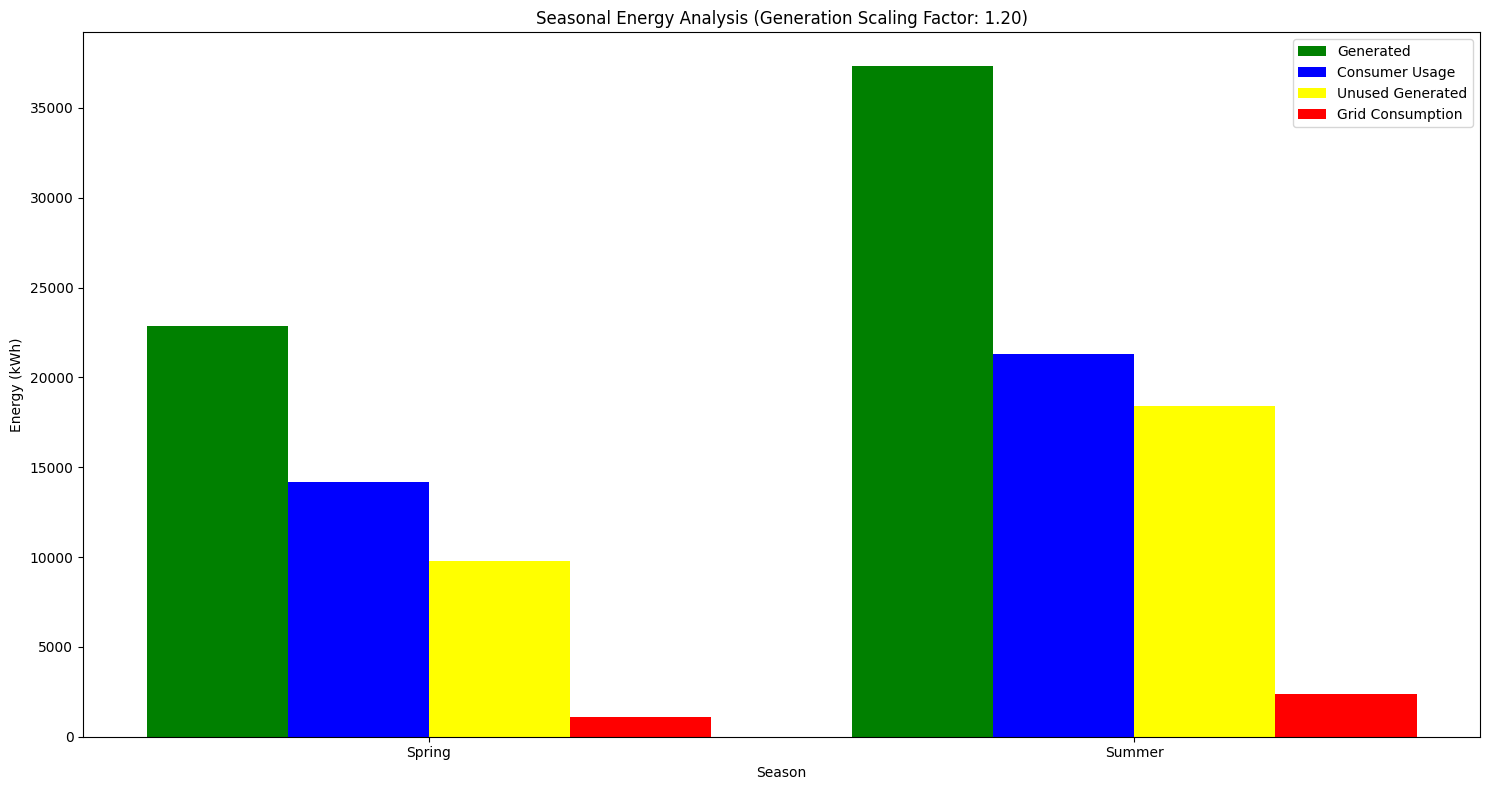

In [22]:
from ipywidgets import interact, FloatSlider

def analyze_energy(*args):
    # Calculate daily energy totals
    daily_energy = pd.merge(
        df_consumption.groupby(df_consumption['datetime'].dt.date)['kW'].sum().reset_index(name='consumer_usage_kWh'),
        df_generation.groupby(df_generation['datetime'].dt.date)['kW'].sum().reset_index(name='generation_kWh'),
        on='datetime'
    )

    # Calculate unused generated energy and grid consumption
    daily_energy['unused_generated_kWh'] = (daily_energy['generation_kWh'] - daily_energy['consumer_usage_kWh']).clip(lower=0)
    daily_energy['grid_consumption_kWh'] = (daily_energy['consumer_usage_kWh'] - daily_energy['generation_kWh']).clip(lower=0)

    # Add season information
    daily_energy['season'] = daily_energy['datetime'].apply(get_season)

    # Calculate total energy metrics
    total_generation = daily_energy['generation_kWh'].sum()
    total_consumer_usage = daily_energy['consumer_usage_kWh'].sum()
    total_unused_generated = daily_energy['unused_generated_kWh'].sum()
    total_grid_consumption = daily_energy['grid_consumption_kWh'].sum()

    print(f"\nOverall Energy Analysis (Generation Scaling Factor: {scaling_factor.value:.2f}):")
    print(f"Total Energy Generated: {total_generation:.2f} kWh")
    print(f"Total Energy Used by Consumer: {total_consumer_usage:.2f} kWh")
    print(f"Total Unused Generated Energy: {total_unused_generated:.2f} kWh")
    print(f"Total Grid Consumption: {total_grid_consumption:.2f} kWh")
    print(f"Percentage of Consumer Usage Covered by Generation: {(total_generation / total_consumer_usage * 100):.2f}%")

    # Analyze by season
    seasonal_energy = daily_energy.groupby('season').agg({
        'generation_kWh': 'sum',
        'consumer_usage_kWh': 'sum',
        'unused_generated_kWh': 'sum',
        'grid_consumption_kWh': 'sum'
    }).reset_index()

    seasonal_energy['generation_coverage_percentage'] = (
        seasonal_energy['generation_kWh'] / seasonal_energy['consumer_usage_kWh'] * 100
    ).clip(upper=100)

    print("\nSeasonal Energy Analysis:")
    for _, row in seasonal_energy.iterrows():
        print(f"\n{row['season']}:")
        print(f"  Energy Generated: {row['generation_kWh']:.2f} kWh")
        print(f"  Energy Used by Consumer: {row['consumer_usage_kWh']:.2f} kWh")
        print(f"  Unused Generated Energy: {row['unused_generated_kWh']:.2f} kWh")
        print(f"  Grid Consumption: {row['grid_consumption_kWh']:.2f} kWh")
        print(f"  Percentage of Consumer Usage Covered by Generation: {row['generation_coverage_percentage']:.2f}%")

    # Plotting
    plt.figure(figsize=(15, 8))
    bar_width = 0.2
    index = range(len(seasonal_energy))

    plt.bar(index, seasonal_energy['generation_kWh'], bar_width, label='Generated', color='green')
    plt.bar([i + bar_width for i in index], seasonal_energy['consumer_usage_kWh'], bar_width, label='Consumer Usage', color='blue')
    plt.bar([i + 2 * bar_width for i in index], seasonal_energy['unused_generated_kWh'], bar_width, label='Unused Generated', color='yellow')
    plt.bar([i + 3 * bar_width for i in index], seasonal_energy['grid_consumption_kWh'], bar_width, label='Grid Consumption', color='red')

    plt.xlabel('Season')
    plt.ylabel('Energy (kWh)')
    plt.title(f'Seasonal Energy Analysis (Generation Scaling Factor: {scaling_factor.value:.2f})')
    plt.xticks([i + 1.5 * bar_width for i in index], seasonal_energy['season'])
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Display daily energy data
    #print("\nDaily Energy Data (first 5 rows):")
    #print(daily_energy.head())
print(f"\nAnalysis completed with Generation Scaling Factor: {scaling_factor.value:.2f}")

scaling_factor.observe(analyze_energy, names='value')
analyze_energy()

# Battery Simulator

In [31]:
battery_capacity = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=1,
    description='Battery Capacity (kWh):',
    continuous_update=False,
    readout_format='d'
)

display(battery_capacity)
print("Adjust the slider to set the battery capacity in kWh.")

IntSlider(value=10, continuous_update=False, description='Battery Capacity (kWh):')

Adjust the slider to set the battery capacity in kWh.



Battery Analysis (Capacity: 10 kWh, Generation Scaling: 1.20):
Total Energy Generated: 60017.92 kWh
Total Energy Consumed: 35502.65 kWh
Energy Stored in Battery: 1057.49 kWh
Energy Used from Battery: 1057.49 kWh
Unused Generated Energy: 33454.90 kWh
Energy Drawn from Grid: 8939.64 kWh
Self-Consumption Rate: 44.26%
Grid Independence Rate: 74.82%


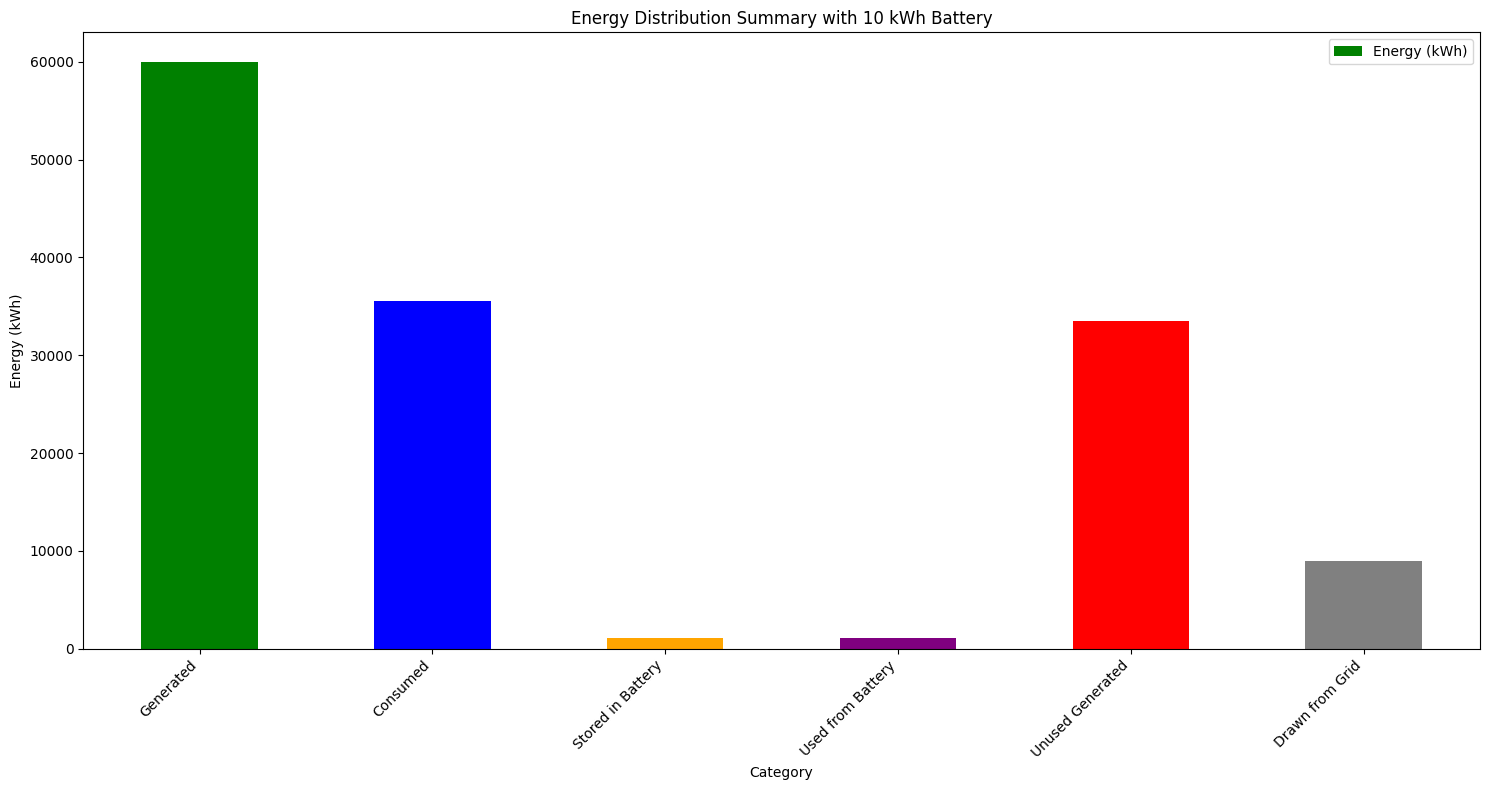

No data available for Winter. Skipping this season.


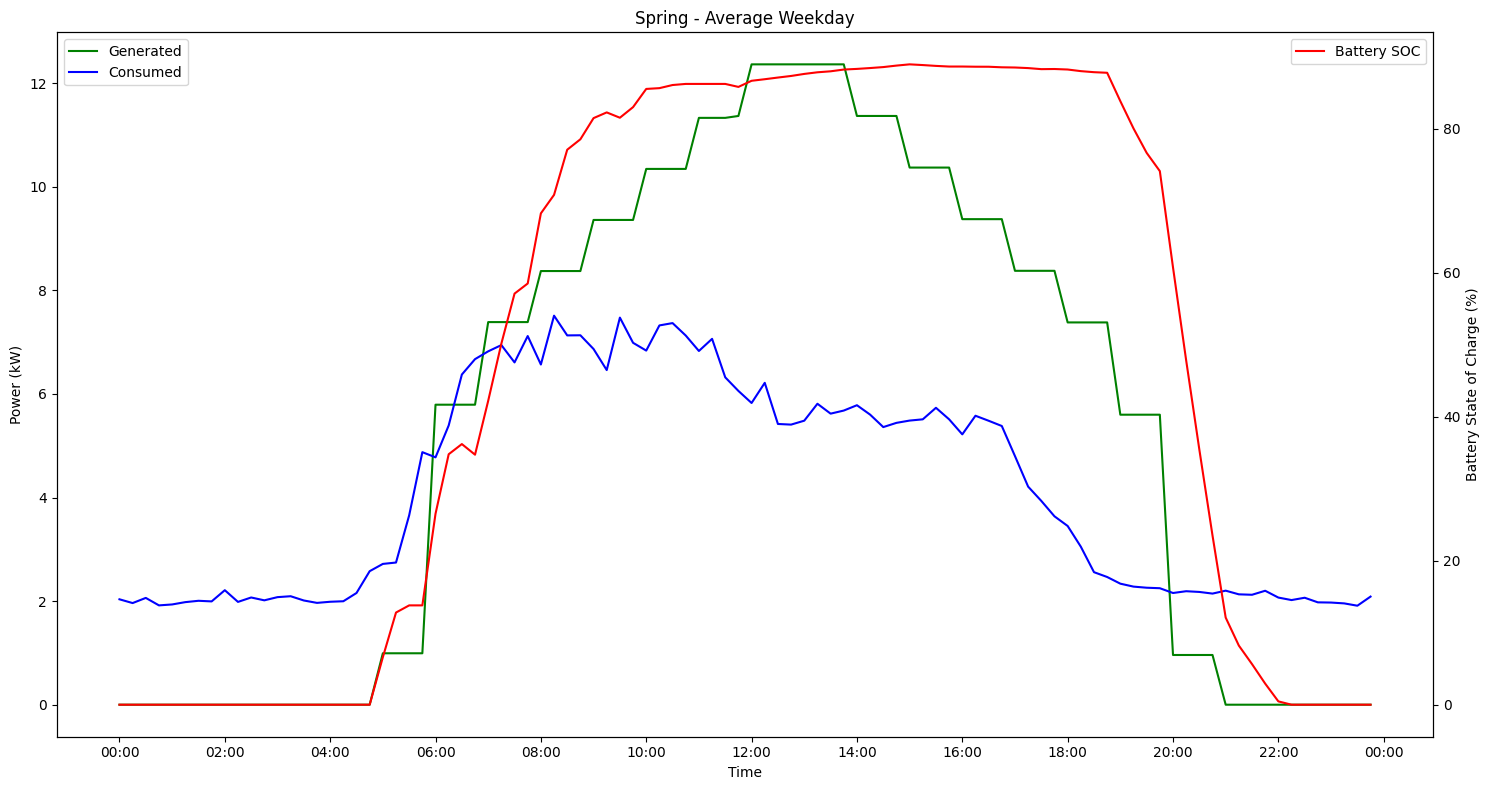

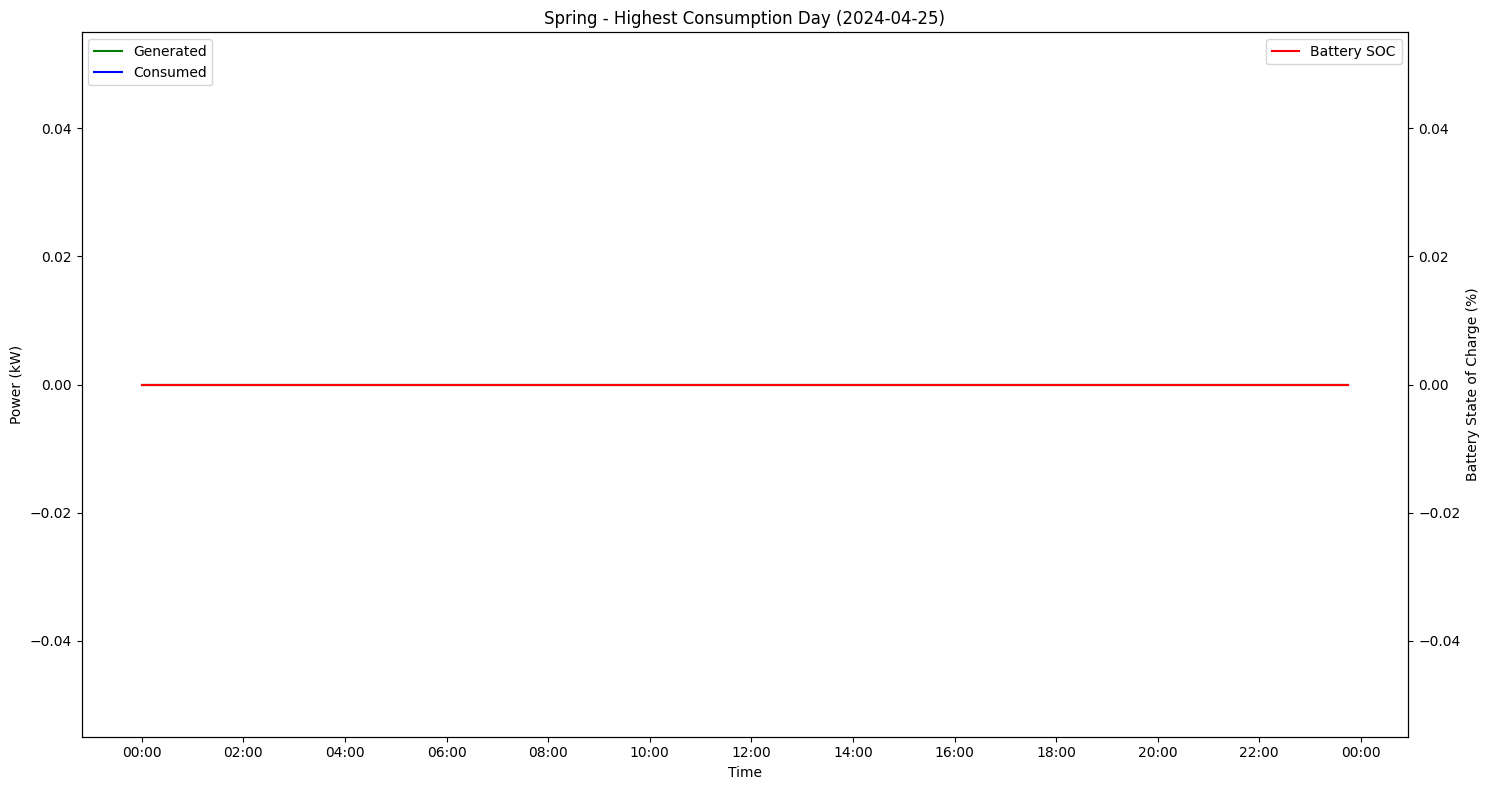

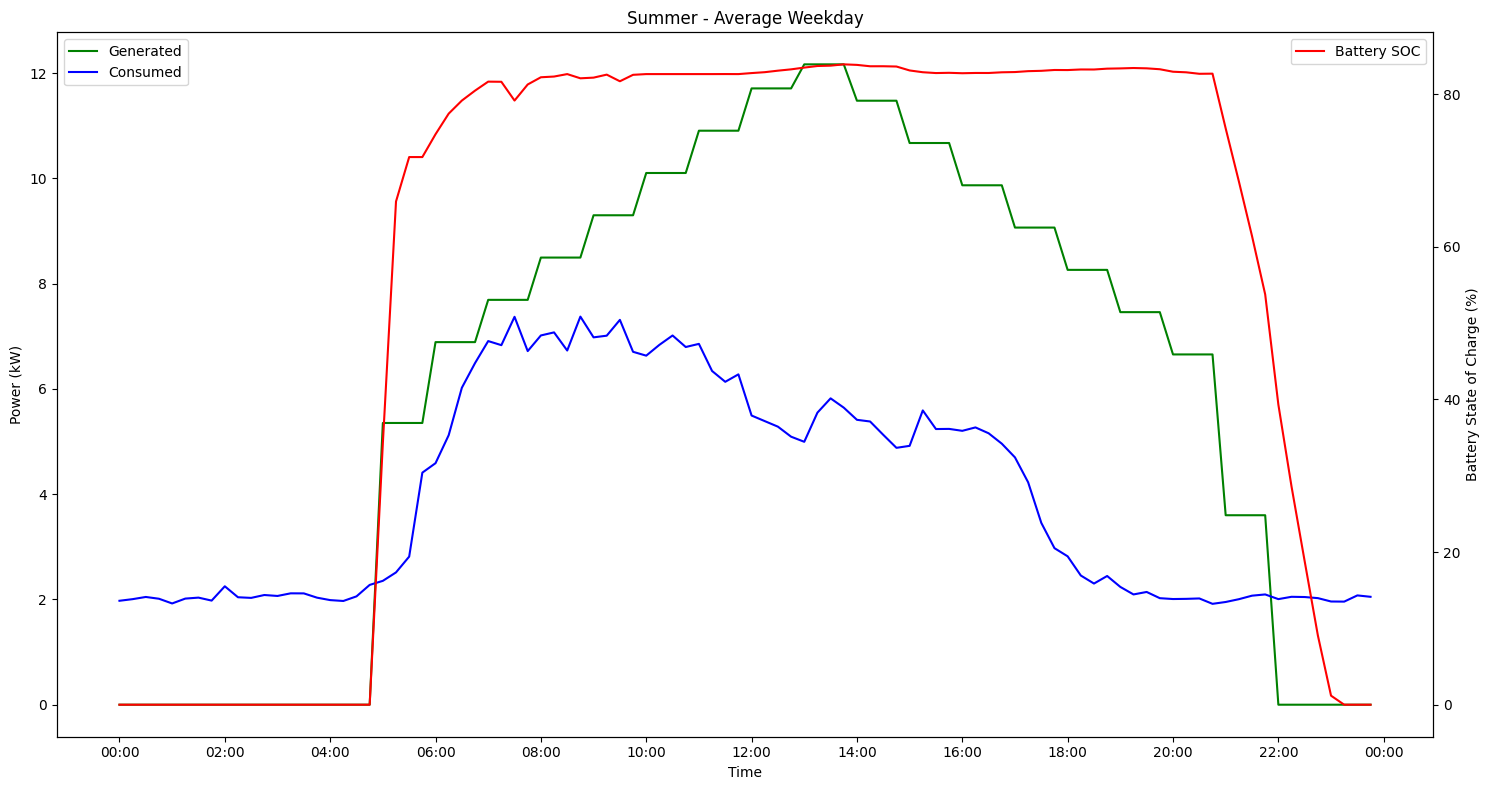

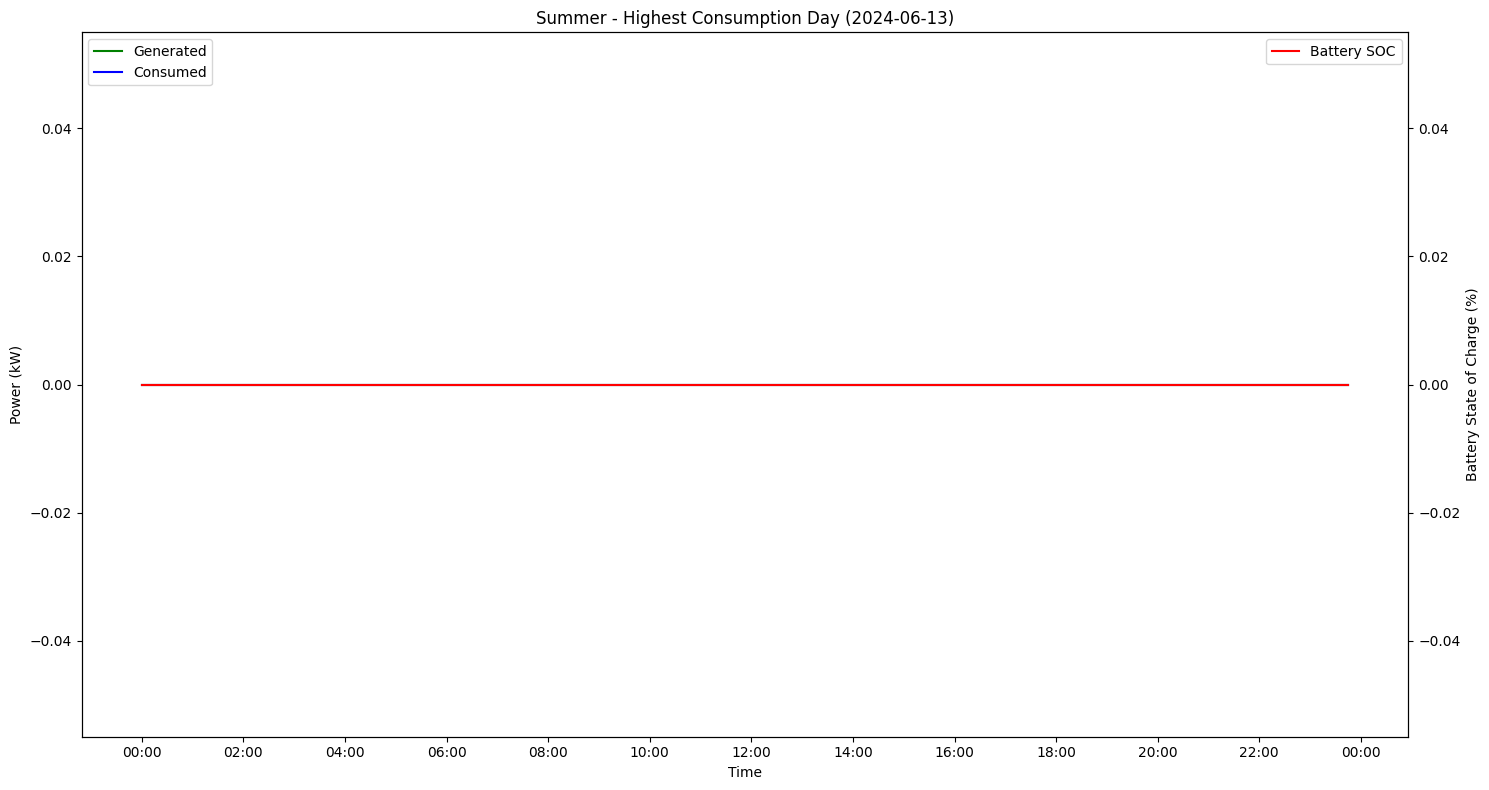

No data available for Autumn. Skipping this season.


In [38]:
import matplotlib.dates as mdates

def analyze_battery_impact(*args):
    global df_consumption, df_generation

    # Resample data to 15-minute intervals
    consumption_15min = df_consumption.resample('15T', on='datetime').sum()
    generation_15min = df_generation.resample('15T', on='datetime').sum()

    # Merge 15-minute data
    energy_15min = pd.merge(
        consumption_15min,
        generation_15min,
        left_index=True,
        right_index=True,
        suffixes=('_consumed', '_generated')
    )

    # Calculate energy surplus/deficit
    energy_15min['energy_surplus'] = energy_15min['kW_generated'] - energy_15min['kW_consumed']

    def simulate_battery(data):
        battery_state = np.zeros(len(data))
        energy_from_battery = np.zeros(len(data))
        energy_to_battery = np.zeros(len(data))
        unused_generated_energy = np.zeros(len(data))
        energy_from_grid = np.zeros(len(data))

        for i, row in enumerate(data.itertuples()):
            if row.energy_surplus > 0:  # Excess energy, can charge battery
                charge_amount = min(row.energy_surplus, battery_capacity.value - battery_state[i-1])
                energy_to_battery[i] = charge_amount
                battery_state[i] = min(battery_state[i-1] + row.energy_surplus, battery_capacity.value)
                unused_generated_energy[i] = max(row.energy_surplus - charge_amount, 0)
            else:  # Energy deficit, need to discharge battery or use grid
                energy_needed = abs(row.energy_surplus)
                energy_from_battery[i] = min(energy_needed, battery_state[i-1])
                battery_state[i] = max(battery_state[i-1] - energy_needed, 0)
                energy_from_grid[i] = max(energy_needed - battery_state[i-1], 0)

        return pd.DataFrame({
            'battery_soc': battery_state / battery_capacity.value * 100,
            'energy_from_battery': energy_from_battery,
            'energy_to_battery': energy_to_battery,
            'unused_generated_energy': unused_generated_energy,
            'energy_from_grid': energy_from_grid
        }, index=data.index)

    # Simulate battery for the entire dataset
    battery_data = simulate_battery(energy_15min)
    energy_15min = pd.concat([energy_15min, battery_data], axis=1)

    # Calculate summary statistics
    total_generated = energy_15min['kW_generated'].sum()
    total_consumed = energy_15min['kW_consumed'].sum()
    total_to_battery = battery_data['energy_to_battery'].sum()
    total_from_battery = battery_data['energy_from_battery'].sum()
    total_unused = battery_data['unused_generated_energy'].sum()
    total_from_grid = battery_data['energy_from_grid'].sum()

    print(f"\nBattery Analysis (Capacity: {battery_capacity.value} kWh, Generation Scaling: {scaling_factor.value:.2f}):")
    print(f"Total Energy Generated: {total_generated:.2f} kWh")
    print(f"Total Energy Consumed: {total_consumed:.2f} kWh")
    print(f"Energy Stored in Battery: {total_to_battery:.2f} kWh")
    print(f"Energy Used from Battery: {total_from_battery:.2f} kWh")
    print(f"Unused Generated Energy: {total_unused:.2f} kWh")
    print(f"Energy Drawn from Grid: {total_from_grid:.2f} kWh")
    print(f"Self-Consumption Rate: {((total_generated - total_unused) / total_generated * 100):.2f}%")
    print(f"Grid Independence Rate: {((total_consumed - total_from_grid) / total_consumed * 100):.2f}%")

    # Plotting summary
    fig, ax = plt.subplots(figsize=(15, 8))
    summary_data = pd.DataFrame({
        'Category': ['Generated', 'Consumed', 'Stored in Battery', 'Used from Battery', 'Unused Generated', 'Drawn from Grid'],
        'Energy (kWh)': [total_generated, total_consumed, total_to_battery, total_from_battery, total_unused, total_from_grid]
    })
    colors = ['green', 'blue', 'orange', 'purple', 'red', 'gray']
    summary_data.plot(kind='bar', x='Category', y='Energy (kWh)', ax=ax, color=colors)
    ax.set_ylabel('Energy (kWh)')
    ax.set_title(f'Energy Distribution Summary with {battery_capacity.value} kWh Battery')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Function to plot daily battery behavior
    def plot_daily_battery(data, title):
        fig, ax1 = plt.subplots(figsize=(15, 8))
        ax2 = ax1.twinx()

        # Create a consistent time index
        time_index = pd.date_range(start='00:00', end='23:59', freq='15T')

        # Reindex the data to match the consistent time index
        data = data.reindex(time_index.time, fill_value=0)

        ax1.plot(time_index, data['kW_generated'], label='Generated', color='green')
        ax1.plot(time_index, data['kW_consumed'], label='Consumed', color='blue')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Power (kW)')
        ax1.legend(loc='upper left')

        ax2.plot(time_index, data['battery_soc'], label='Battery SOC', color='red')
        ax2.set_ylabel('Battery State of Charge (%)')
        ax2.legend(loc='upper right')

        plt.title(title)
        plt.xticks(rotation=45)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        plt.tight_layout()
        plt.show()

    # Plot average weekday and max consumption day for each season
    for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
        season_data = energy_15min[energy_15min.index.to_series().apply(get_season) == season]

        if season_data.empty:
            print(f"No data available for {season}. Skipping this season.")
            continue

        # Average weekday
        weekday_data = season_data[season_data.index.dayofweek < 5].reset_index()
        weekday_data['time'] = weekday_data['datetime'].dt.time
        # Select only numeric columns for mean calculation
        numeric_columns = weekday_data.select_dtypes(include=[np.number]).columns
        weekday_data = weekday_data.groupby('time')[numeric_columns].mean()
        if not weekday_data.empty:
            plot_daily_battery(weekday_data, f'{season} - Average Weekday')
        else:
            print(f"No weekday data available for {season}.")

        # Day with max consumption
        daily_consumption = season_data.resample('D')['kW_consumed'].sum()
        if not daily_consumption.empty:
            max_consumption_day = daily_consumption.idxmax()
            max_day_data = season_data[season_data.index.date == max_consumption_day.date()]
            if not max_day_data.empty:
                max_day_data = max_day_data.reset_index().set_index('datetime').sort_index()
                plot_daily_battery(max_day_data, f'{season} - Highest Consumption Day ({max_consumption_day.date()})')
            else:
                print(f"No data available for the highest consumption day in {season}.")
        else:
            print(f"No daily consumption data available for {season}.")

# Observe changes in scaling factor and battery capacity
scaling_factor.observe(analyze_battery_impact, names='value')
battery_capacity.observe(analyze_battery_impact, names='value')

# Initial run of battery analysis
analyze_battery_impact()